In [3]:
%load_ext autoreload
%autoreload 2
import math
import sys
import os

import uproot
import numpy as np
import pandas as pd
import awkward as ak

import matplotlib
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

sys.path.append("../..")
from hists.parameters import synchrotronBeamEnergiesMap, beamEnergies
from ratios_utils import makeFrequencyPerBeamEnergy
from HistogramLib.store import HistogramStore
from hists.store import HistogramId

In [4]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v38'
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data", "sim_proton_v46_patchMIP":"Simulation"}
datatypes = ["data", "sim_proton_v46_patchMIP"]

def loadTree(datatype):
    path = os.path.join(hist_folder, clueParams, datatype, "CLUE_clusters.root:clusters")
    tree = uproot.open(path)
    return tree

In [5]:
def findEventsWithHighMaxMeanEnergyLayer(tree, minMaxEnergyLayer=13, stopAfter=math.inf):
    """ Find events where the main trackster size is less than sizeThreshold
    """
    filtered_arrays = []
    count = 0
    for array in tree.iterate(step_size="100MB", library="ak", 
            filter_name=["event", "ntupleNumber", "beamEnergy", "rechits_layer", "rechits_energy"]):
        layerWithMaxEnergy = ak.argmax(
            ak.sum(
                # Group energy by layer : make array of the form [[energies on layer 1], [energies on layer 2], ...]
                ak.unflatten(array.rechits_energy, ak.flatten(ak.run_lengths(array.rechits_layer)), axis=-1), 
            axis=-1), 
        axis=-1)
        cut = layerWithMaxEnergy >= minMaxEnergyLayer
        filtered_arrays.append(ak.copy(array[cut]))
        count += np.sum(cut)
        if count > stopAfter:
            break
    return ak.drop_none(ak.concatenate(filtered_arrays))

In [6]:
def makeDict(minMaxEnergyLayer=15):
    return {datatype : findEventsWithHighMaxMeanEnergyLayer(loadTree(datatype), minMaxEnergyLayer=minMaxEnergyLayer) for datatype in datatypes}

In [7]:
evts_dict = makeDict(13)

In [8]:
def plotFrequencyPerBeamEnergy(series_dict:dict[str, pd.Series], ax=None, alternative_hypothesis="two-sided", datatypeToLegendMap={"data":"Data", "sim_proton_v46_patchMIP":"Simulation"}):
    """ Plot the frequency of occurence per beam energy, given a set of beam energy values to histogram
    Parameters : 
     - series : datatype -> (series of beam energies to histogram)
     - settings : dict to plot on top right
     - alternative_hypothesis : two-sided or greater 
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    errorbar_kwargs = dict()
    if alternative_hypothesis == "greater":
        errorbar_kwargs["lolims"] = True

    offset_x = 3
    cur_offset = 0
    for datatype, series in series_dict.items():
        ratio_val, ratio_errors = makeFrequencyPerBeamEnergy(histStore, clueParams, series, datatype)
        ax.errorbar(x=np.array(beamEnergies)+cur_offset, y=ratio_val, yerr=ratio_errors, fmt="o-", #ecolor="black", 
                     label=datatypeToLegendMap.get(datatype, datatype), **errorbar_kwargs)
        cur_offset += offset_x

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
    ax.set_xlabel("Beam energy (GeV)")
    ax.set_ylabel("Fraction of high maxEnergyLayer")
    hep.cms.text("Preliminary", ax=ax)
    hep.cms.lumitext("$e^+$ TB", ax=ax)
    ax.legend()
    return fig, ax
    #return ratio_val, ratio_errors

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: xlabel='Beam energy (GeV)', ylabel='Fraction of high maxEnergyLayer'>)

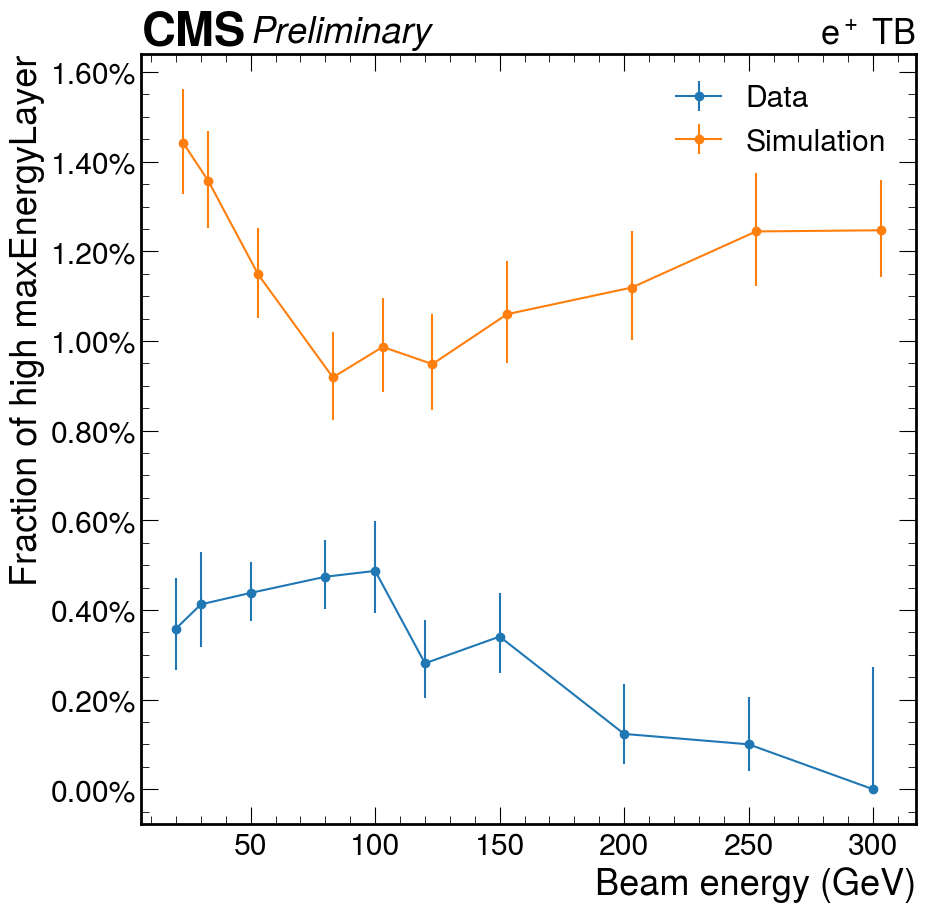

In [9]:
#makeFrequencyPerBeamEnergy(histStore, clueParams, evts_data.beamEnergy, "data")
plotFrequencyPerBeamEnergy({datatype : ar.beamEnergy for datatype, ar in evts_dict.items()})

In [10]:
def randomSample(datatype, beamEnergy=None, size=5):
    ar = evts_dict[datatype]
    if beamEnergy is not None:
        ar = ar[ar.beamEnergy == beamEnergy]
    return ar[np.random.choice(len(ar), size=size)]

In [11]:
randomSample("sim_proton_v46_patchMIP", 300)

<Array [{beamEnergy: 300, ...}, ..., {...}] type='5 * {beamEnergy: float32,...'>